In [1]:
#Standard Header used on the projects

#first the major packages used for math and graphing
import numpy as np
import matplotlib.pyplot as plt
from cycler import cycler
import scipy.special as sp
import pandas as pd

#Custome graph format style sheet
#plt.style.use('Prospectus.mplstyle')

#If being run by a seperate file, use the seperate file's graph format and saving paramaeters
#otherwise set what is needed
if not 'Saving' in locals():
    Saving = True
if not 'Titles' in locals():
    Titles = True
if not 'Ledgends' in locals():
    Ledgends = True
if not 'FFormat' in locals():
    FFormat = '.png'

Computer = "SciClone"   # "SciClone"    "WinLap"  "LinLap"   "Desktop"  "PortLap"

#Standard cycle for collors and line styles
default_cycler = (cycler('color', ['0.00', '0.40', '0.60', '0.70']) + cycler(linestyle=['-', '--', ':', '-.']))
plt.rc('axes', prop_cycle=default_cycler)
my_cmap = plt.get_cmap('gray')
PlotWidthIn = 11
PlotHeightIn = 3.75
PlotDPI = 120

Groups = 1
GroupSize = 15


RollingSize = 25

In [2]:
import multiprocessing
from joblib import Parallel, delayed

import pywt
from pywt._extensions._pywt import (DiscreteContinuousWavelet, ContinuousWavelet,
                                Wavelet, _check_dtype)
from pywt._functions import integrate_wavelet, scale2frequency 

In [3]:
from scipy.optimize import curve_fit

In [4]:
if Computer == "SciClone":
    location = '/sciclone/home20/dchendrickson01/image/'
elif Computer == "WinLap":
    location = 'C:\\Data\\'
elif Computer == "Desktop":
    location = "E:\\Backups\\Dan\\CraneData\\"
elif Computer == "LinLap":
    location = '/home/dan/Output/'
elif Computer == 'PortLap':
    location = 'C:\\users\\dhendrickson\\Desktop\\AccelData\\'
    

if Computer ==  "SciClone":
    rootfolder = '/sciclone/home20/dchendrickson01/'
    folder = '/sciclone/data10/dchendrickson01/SmallCopy/'
elif Computer == "Desktop":
    rootfolder = location
    folder = rootfolder + "SmallCopy\\"
elif Computer =="WinLap":
    rootfolder = location
    folder = rootfolder + "SmallCopy\\"   
elif Computer == "LinLap":
    rootfolder = '/home/dan/Data/'
    folder = rootfolder + 'SmallCopy/'
elif Computer =='PortLap':
    rootfolder = location 
    folder = rootfolder + 'SmallCopy\\'

In [5]:
#Extra Headers:
import os as os
import statistics as st
import os as os
import pandas as pd
import random
import multiprocessing
from joblib import Parallel, delayed
import time

In [6]:
#Columns names for a file with all 6 dimmensions
Header = np.array(['t', 's','x','y','z','s'])

In [7]:
def low_pass_filter(data_in, wvt='sym2', dets_to_remove=5, levels=None):
    '''
    Function to filter out high frequency noise from a data signal. Usually 
    perform this before running the DWFT on the signal.
    
    data_in: input signal
    
    wvt: mother wavelet

    levels: number of levels to take in transformation

    dets_to_remove: details to remove in filter
    '''
    # vector needs to have an even length, so just zero pad if length is odd.
    if len(data_in) % 2 != 0:
        data_in = np.append(data_in, 0)
    
    coeffs = pywt.swt(data_in, wvt, level=levels)
    
    if levels is None:
        levels = len(coeffs)
    
    for i in range(dets_to_remove):
        dets = np.asarray(coeffs[(levels-1)-i][1])
        dets[:] = 0
    
    filtered_signal = pywt.iswt(coeffs,wvt)
    return filtered_signal

In [8]:
def get_primelist(upper):
    result=[]
    for cp in range(2,upper+1):
        for i in range(2,cp):
            if cp%i ==0:
                break
        else:
            result.append(cp)
    return result


In [9]:
def cwt_fixed(data, scales, wavelet, scalespace =1, sampling_period=1.):
    """
    COPIED AND FIXED FROM pywt.cwt TO BE ABLE TO USE WAVELET FAMILIES SUCH
    AS COIF AND DB

    COPIED From Spenser Kirn
    
    All wavelet work except bior family, rbio family, haar, and db1.
    
    cwt(data, scales, wavelet)

    One dimensional Continuous Wavelet Transform.

    Parameters
    ----------
    data : array_like
        Input signal
    scales : array_like
        scales to use
    wavelet : Wavelet object or name
        Wavelet to use
    sampling_period : float
        Sampling period for frequencies output (optional)

    Returns
    -------
    coefs : array_like
        Continous wavelet transform of the input signal for the given scales
        and wavelet
    frequencies : array_like
        if the unit of sampling period are seconds and given, than frequencies
        are in hertz. Otherwise Sampling period of 1 is assumed.

    Notes
    -----
    Size of coefficients arrays depends on the length of the input array and
    the length of given scales.

    Examples
    --------
    >>> import pywt
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> x = np.arange(512)
    >>> y = np.sin(2*np.pi*x/32)
    >>> coef, freqs=pywt.cwt(y,np.arange(1,129),'gaus1')
    >>> plt.matshow(coef) # doctest: +SKIP
    >>> plt.show() # doctest: +SKIP
    ----------
    >>> import pywt
    >>> import numpy as np
    >>> import matplotlib.pyplot as plt
    >>> t = np.linspace(-1, 1, 200, endpoint=False)
    >>> sig  = np.cos(2 * np.pi * 7 * t) + np.real(np.exp(-7*(t-0.4)**2)*np.exp(1j*2*np.pi*2*(t-0.4)))
    >>> widths = np.arange(1, 31)
    >>> cwtmatr, freqs = pywt.cwt(sig, widths, 'mexh')
    >>> plt.imshow(cwtmatr, extent=[-1, 1, 1, 31], cmap='PRGn', aspect='auto',
    ...            vmax=abs(cwtmatr).max(), vmin=-abs(cwtmatr).max())  # doctest: +SKIP
    >>> plt.show() # doctest: +SKIP
    """
    
    scales = get_primelist(10000)
    
    # accept array_like input; make a copy to ensure a contiguous array
    dt = _check_dtype(data)
    data = np.array(data, dtype=dt)
    if not isinstance(wavelet, (ContinuousWavelet, Wavelet)):
        wavelet = DiscreteContinuousWavelet(wavelet)
    if np.isscalar(scales):
        scales = np.r_[1:scales+1] * scalespace
    if data.ndim == 1:
        try:
            if wavelet.complex_cwt:
                out = np.zeros((np.size(scales), data.size), dtype=complex)
            else:
                out = np.zeros((np.size(scales), data.size))
        except AttributeError:
            out = np.zeros((np.size(scales), data.size))
        precision = 10
        int_psi, x = integrate_wavelet(wavelet, precision=precision)
        step = x[1] - x[0]
        for i in np.arange(np.size(scales)):
            j = np.floor(
                np.arange(scales[i] * (x[-1] - x[0]) + 1) / (scales[i] * step))
            if np.max(j) >= np.size(int_psi):
                j = np.delete(j, np.where((j >= np.size(int_psi)))[0])
            coef = - np.sqrt(scales[i]) * np.diff(np.convolve(data, int_psi[j.astype(int)][::-1]))
            d = (coef.size - data.size) / 2.
            out[i, :] = coef[int(np.floor(d)):int(-np.ceil(d))]
        #frequencies = scale2frequency(wavelet, scales, precision)
        #if np.isscalar(frequencies):
        #    frequencies = np.array([frequencies])
        #for i in np.arange(len(frequencies)):
        #    frequencies[i] /= sampling_period
        return out
    else:
        raise ValueError("Only dim == 1 supported")



In [10]:
WaveletToUse = 'gaus2'
#scales = np.linspace(0,2000,1001, dtype=int)
scales = 500
spacer = 10
    


def getThumbprint(data, wvt=WaveletToUse, ns=scales, scalespace = spacer, numslices=5, slicethickness=0.12, 
                  valleysorpeaks='both', normconstant=1, plot=False):
    '''
    Updated version of the DWFT function above that allows plotting of just
    valleys or just peaks or both. To plot just valleys set valleysorpeaks='valleys'
    to plot just peaks set valleysorpeaks='peaks' or 'both' to plot both.
    '''
    # First take the wavelet transform and then normalize to one
    if np.shape(data)[0] == 2:
        wvt = data[1]
        data = data[0]
    
    try:
        cfX = cwt_fixed(data, ns, wvt,scalespace)
        cfX = np.true_divide(cfX, abs(cfX).max()*normconstant)
        
        ns = np.shape(cfX)[0]
        
        fp = np.zeros((len(data), ns), dtype=int)

        # Create the list of locations between -1 and 1 to preform slices. Valley
        # slices will all be below 0 and peak slices will all be above 0.
        if valleysorpeaks == 'both':
            slicelocations1 = np.arange(-1 ,0.0/numslices, 1.0/numslices)
            slicelocations2 = np.arange(1.0/numslices, 1+1.0/numslices, 1.0/numslices)
            slicelocations = np.array(np.append(slicelocations1,slicelocations2))

        if valleysorpeaks == 'peaks':
            slicelocations = np.arange(1.0/numslices, 1+1.0/numslices, 1.0/numslices)

        if valleysorpeaks == 'valleys':
            slicelocations = np.arange(-1, 0.0/numslices, 1.0/numslices)

        for loc in slicelocations:
            for y in range(0, ns):
                for x in range(0, len(data)):
                    if cfX[y, x]>=(loc-(slicethickness/2)) and cfX[y,x]<= (loc+(slicethickness/2)):
                        fp[x,y] = 1

        fp = np.transpose(fp[:,:ns])
    except:
        fp = 'fail'
    
    return fp

In [11]:

def getThumbprint2(data, wvt=WaveletToUse, ns=scales, scalespace = spacer, numslices=5, slicethickness=0.12, 
                  valleysorpeaks='both', normconstant=1, plot=False):
    '''Attempt to speed code where the comparisons happen too many times too slowly
    '''
    
        # First take the wavelet transform and then normalize to one
    if np.shape(data)[0] == 2:
        wvt = data[1]
        data = data[0]
    
    #try:
    cfX = cwt_fixed(data, ns, wvt,scalespace)

    fp = np.zeros((len(data), ns), dtype=int)

    minVal = min(cfX)
    maxVal = max(cfX)
    rangeVal = maxVal - minVal#

    cfX -= minVal
    cfX /= rangeVal

    cfX *= float(numslices +1)
    
    cfX += 0.5

    cfX = int(cfX)

    cfX = np.mod(cfX, 2)


    rangeScale = rangeVal / numslices

    fp = np.transpose(fp[:,:ns])
    #except:
    
    #fp = 'fail'
    
    return fp

In [12]:
def getScalesOnly(data, wvt=WaveletToUse, ns=scales, scalespace = spacer, numslices=5, slicethickness=0.12, 
                  valleysorpeaks='both', normconstant=1, plot=False):
    '''Attempt to speed code where the comparisons happen too many times too slowly
    '''
    if np.shape(data)[0] == 2:
        wvt = data[1]
        data = data[0]
    
    #try:
    cfX = cwt_fixed(data, ns, wvt,scalespace)

    return cfX

In [13]:
def PlotFingerPrint(Input):
    
    #FpScat=fp.getLabeledThumbprint(data, FP,scales,slices)
    #print(np.shape(data)[1], scales)

    
    data = Input[0]
    title = Input[1]
    
    scales = np.shape(data)[0]
    trim=0
    slices = 3
    Show = False
    
    xName = np.arange(0,np.shape(data)[1]-2*trim,1)
    
    if trim == 0:
        Al,Ms  = np.meshgrid(xName,np.linspace(1,scales,scales))
    else:
        Al,Ms  = np.meshgrid(xName,np.linspace(1,scales,scales))

    

    fig1 = plt.figure(figsize=(PlotWidthIn,PlotHeightIn),dpi=PlotDPI)
    ax1 = plt.axes()
    if trim == 0:
        cs1 = ax1.contourf(Al,Ms, data[:,:],cmap=my_cmap,levels=slices)
    else:
        cs1 = ax1.contourf(Al,Ms, data[:,trim:-trim],cmap=my_cmap,levels=slices)

    if Titles: plt.title(title)
    if Saving: plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "").replace(".txt","")+FFormat)

    if Show: plt.show()
    else: plt.close()
        
    return 1

In [14]:
def PlotColorScales(Input):
    
    #FpScat=fp.getLabeledThumbprint(data, FP,scales,slices)
    #print(np.shape(data)[1], scales)

    
    data = Input[0]
    title = Input[1]
    
    scales = np.shape(data)[0]
    trim=0
    #slices = 3
    Show = False
    
    xName = np.arange(0,np.shape(data)[1]-2*trim,1)
    
    if trim == 0:
        Al,Ms  = np.meshgrid(xName,np.linspace(1,scales,scales))
    else:
        Al,Ms  = np.meshgrid(xName,np.linspace(1,scales,scales))

    

    fig1 = plt.figure(figsize=(PlotWidthIn,PlotHeightIn),dpi=PlotDPI)
    ax1 = plt.axes()
    if trim == 0:
        cs1 = ax1.contourf(Al,Ms, data[:,:],cmap='jet',levels=256)
    else:
        cs1 = ax1.contourf(Al,Ms, data[:,trim:-trim],cmap='jet',levels=256)

    if Titles: plt.title(title)
    if Saving: plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "").replace(".txt","")+FFormat)

    if Show: plt.show()
    else: plt.close()
        
    return 1

In [15]:
#opens all files in a folder and returns the 3 axis acceleration in one array
# made to run in parallel

def getAcceleration(FileName):
    
        DataSet = np.genfromtxt(open(FileName,'r'), delimiter=',',skip_header=0)
        JustFileName = FileName.rsplit('/', 1)[-1]
        if FileName[-20:-16] == 'Gyro':
            return [False,FileName,False]
        else:
            if FileName[-6:-5] == 's':
                FileDate = FileName[-18:-7]
                sensor = FileName[-5:-4]
            elif FileName[-21:-16] == 'Accel':
                FileDate = FileName[-15:-4]
                sensor = 1
            else:
                FileDate = FileName[-20:-4]
                sensor = 1
            return [[FileDate, 'x',DataSet[:,2], sensor,JustFileName],[FileDate,'y',DataSet[:,3],sensor,JustFileName],[FileDate,'z',DataSet[:,4],sensor,JustFileName]]
    

In [16]:
def KalmanFilterDenoise(data, rate=1):

    #https://jamwheeler.com/college-productivity/how-to-denoise-a-1-d-signal-with-a-kalman-filter-with-python/
    #

    def oavar(data, rate, numpoints=30):

        x = np.cumsum(data)

        max_ratio = 1/9
        num_points = 30
        ms = np.unique(
            np.logspace(0, np.log10(len(x) * max_ratio), numpoints
           ).astype(int))        

        oavars = np.empty(len(ms))
        for i, m in enumerate(ms):
            oavars[i] = (
                (x[2*m:] - 2*x[m:-m] + x[:-2*m])**2
            ).mean() / (2*m**2)

        return ms / rate, oavars

    def ln_NKfit(ln_tau, ln_N, ln_K):
        tau = np.exp(ln_tau)
        N, K = np.exp([ln_N, ln_K])
        oadev = N**2 / tau + K**2 * (tau/3)
        return np.log(oadev)

    def get_NK(data, rate):
        taus, oavars = oavar(data, rate)

        ln_params, ln_varmatrix = (
            curve_fit(ln_NKfit, np.log(taus), np.log(oavars))
        )
        return np.exp(ln_params)    

    # Initialize state and uncertainty
    state = data[0]
    output = np.empty(len(data))

    #rate = 1 # We can set this to 1, if we're calculating N, K internally
    # N and K will just be scaled relative to the sampling rate internally
    dt = 1/rate

    N, K = get_NK(data, rate)

    process_noise = K**2 * dt
    measurement_noise = N**2 / dt

    covariance = measurement_noise

    for index, measurement in enumerate(data):
        # 1. Predict state using system's model

        covariance += process_noise

        # Update
        kalman_gain = covariance / (covariance + measurement_noise)

        state += kalman_gain * (measurement - state)
        covariance = (1 - kalman_gain) * covariance

        output[index] = state

    return output

In [17]:
#Inputs:
#folder1 = 'C:\\Users\\Hendrickson\\Desktop\\Phone Acceleration\\'
#folder2 = 'E:\\Documents\\Dan\\PhD\\Data Backup\\ASC Accel Pi\\Excel Versions\\'
#folder = "E:\\Documents\\Dan\\Port Work\\OneDrive\OneDrive - The Port of Virginia\\Shared with Everyone\\Crane Data\\"
#folder = "C:\\Users\\Dan\\Desktop\\TempData\\"


files = os.listdir(folder)


In [18]:
#Pre Calculations

num_cores = multiprocessing.cpu_count()-1

if np.shape(files)[0] < GroupSize:
    GroupSize = np.shape(files)[0]

if Groups !=0:
    files = random.sample(files,GroupSize*Groups)

loops = int(float(np.size(files))/float(GroupSize))+1
start = time.time()

inverseRollingSize = 1 / RollingSize

AllAccels = np.asarray([],dtype=object)
for file in files:
    print(file)
    temp = getAcceleration(folder + file)
    if np.size(AllAccels)==0:
        AllAccels = temp
    else:
        AllAccels = np.concatenate((AllAccels,temp), axis =0)

In [19]:
AllAccels = Parallel(n_jobs=num_cores)(delayed(getAcceleration)(folder+file) for file in files)


In [20]:
MetaData = []  #np.asarray([],dtype=object)
DataOnlyMatrix = np.asarray([],dtype=object)
for j in range(np.shape(AllAccels)[0]):
    if AllAccels[j][0] == False :
        if AllAccels[j][1][4:9] =='Accel':
            print(j,AllAccels[j][1])
    else: 
        for k in range(3):
            MetaData.append([AllAccels[j][k][0], AllAccels[j][k][1], AllAccels[j][k][3], AllAccels[j][k][4]])
            if np.size(DataOnlyMatrix) == 0:
                    DataOnlyMatrix =np.matrix(AllAccels[j][k][2])
            else:
                    DataOnlyMatrix = np.concatenate((DataOnlyMatrix,np.matrix(AllAccels[j][k][2])),axis=0)

MetaData = np.matrix(MetaData)

/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)


waveFiltered = np.asarray([],dtype=object)
waveFiltered = Parallel(n_jobs=num_cores)(delayed(low_pass_filter)(np.asarray(data).flatten()) for data in DataOnlyMatrix)
waveFiltered = np.matrix(waveFiltered)


length = np.shape(waveFiltered)[0]
justifier = np.ones((length, np.shape(waveFiltered)[1]))
average = np.zeros(length)
for i in range(length):
    average[i]= np.average(waveFiltered[i][:])
justifier = justifier.T * average.T
waveFiltered = waveFiltered - justifier.T

In [21]:
waveKalmaned = np.asarray([],dtype=object)
waveKalmaned = Parallel(n_jobs=num_cores)(delayed(KalmanFilterDenoise)(np.asarray(data).flatten()) for data in DataOnlyMatrix)
waveKalmaned = np.matrix(waveKalmaned)


/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: 

In [22]:
length = np.shape(waveKalmaned)[0]
justifier = np.ones((length, np.shape(waveKalmaned)[1]))
average = np.zeros(length)
for i in range(length):
    average[i]= np.average(waveKalmaned[i][:])
justifier = justifier.T * average.T
waveKalmaned = waveKalmaned - justifier.T

DataOnlyMatrix = np.matrix(DataOnlyMatrix)

length = np.shape(DataOnlyMatrix)[1]
halfLength = int(length / 2)

Weights1 = np.zeros((halfLength,halfLength))
Weights2 = np.zeros((halfLength,halfLength+RollingSize-1))

for j in range(halfLength):
    r = j+1

    if r < RollingSize:
        ir = 1/ r
        for k in range(r):
            Weights1[k,j] = ir
    else:
        for k in range(RollingSize):
            Weights1[r-RollingSize+k, j] = inverseRollingSize
    for k in range(RollingSize):
        Weights2[j,j+k] = inverseRollingSize

FirstBit = np.dot(DataOnlyMatrix[:,:halfLength], Weights1)
Weights1 = []

if length % 2 == 1: halfLength += 1
Weights2=Weights2[:,:halfLength]
SecondBit = np.dot(DataOnlyMatrix[:,halfLength:], Weights2)

Weights2 = [] 

Weights3 = np.zeros((halfLength,halfLength))
for j in range(RollingSize-1):
    for k in range(RollingSize-j-1):
        Weights3[halfLength-k-1,j] = inverseRollingSize

SecondBit = SecondBit + np.dot(DataOnlyMatrix[:,halfLength:], Weights3)
Weights3 = []

Averages = np.concatenate((FirstBit, SecondBit), axis=1)

In [23]:
j=4
s=0
e=0


length = np.shape(Averages)[0]
justifier = np.ones((length, np.shape(Averages)[1]))
average = np.zeros(length)
for i in range(length):
    average[i]= np.average(Averages[i,:])
justifier = justifier.T * average.T
Averages = Averages - justifier.T
DataOnlyMatrix = DataOnlyMatrix - justifier.T


In [24]:
maxes = np.amax(waveKalmaned[:,500:], axis = 1)
mins = np.amin(waveKalmaned[:,500:], axis = 1)

Keep = np.zeros(mins.size)
for i in range(mins.size):
    if i % 3 == 0:
        if maxes[i] > 0.01 and mins[i] < -0.01:
            Keep[i]=1
            #Keep[i+1]=1
            #Keep[i+2]=1
            print(i)
            

Keep = np.array(Keep, dtype='bool')
            
waveKalmaned = waveKalmaned[Keep,:]
MetaData = MetaData[Keep,:]

0
6
9
18
21
30
36
42


In [25]:
if e ==0: e = 60
s=s*1000
e=e*1000
for j in range(np.shape(waveKalmaned)[0]):
    if j %3 ==0:
        fig = plt.figure(figsize=(PlotWidthIn,PlotHeightIn),dpi=PlotDPI)
        #plt.plot(DataOnlyMatrix[j,s:e].T)
        #plt.plot(Averages[j,s:e].T)
        #plt.plot(waveFiltered[j][s:e].T)
        plt.plot(waveKalmaned[j][s:e].T)
        title = str(MetaData[j,0]) + '  ' + str(MetaData[j,1])+ '    ' +str(j)
        plt.title(title)
        plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "")+FFormat)
        plt.close(fig)

#del DataOnlyMatrix

In [26]:
MetaData[0]

matrix([['220211-1607', 'x', '4', '60kPoints-220211-1607-s4.csv']],
       dtype='<U28')

In [27]:
#FPs = Parallel(n_jobs=num_cores)(delayed(getThumbprint)(motion) for motion in Averages)
#del Averages

#ToPlot=[]
#for i in range(np.shape(FPs)[0]):
#    if MetaData[i][1] == 'x':
#        title = 'FP-'+MetaData[i][0]+'  ' + MetaData[i][1]+ '    ' +str(i)
#        ToPlot.append([FPs[i], title])

In [28]:
#FPs = Parallel(n_jobs=num_cores)(delayed(PlotFingerPrint)(FP) for FP in ToPlot)

In [29]:
WvltFam = pywt.families()
Wvlts = []
for Fam in WvltFam:
    temp = pywt.wavelist(Fam)
    for wvlt in temp:
        Wvlts.append(wvlt)

In [30]:
#Bestmove = 0

In [31]:
Bestmove = input('What movement? ')

What movement? 3


In [32]:
Wvlts = np.asarray(Wvlts)
Wvlts = Wvlts.flatten()
#AvgChoosen = np.asarray(Averages[int(Bestmove)]).flatten()
#AvgChoosen = np.asarray(waveFiltered[int(Bestmove)]).flatten()
AvgChoosen = np.asarray(waveKalmaned[int(Bestmove)]).flatten()

data = AvgChoosen
wvt=WaveletToUse
ns=scales
scalespace = spacer
numslices=5
slicethickness=0.12
valleysorpeaks='both'
normconstant=1
plot=False
if np.shape(data)[0] == 2:
    wvt = data[1]
    data = data[0]
#try:
cfX, freqs = cwt_fixed(data, ns, wvt,scalespace)
fp = np.zeros((len(data), ns), dtype=int)

minVal = np.min(cfX)
maxVal = np.max(cfX)
rangeVal = maxVal - minVal#

cfX -= minVal
cfX /= rangeVal

cfX *= float(numslices +1)
cfX = cfX.astype(int)

cfx = np.mod(cfX, 2)


rangeScale = rangeVal / numslices

fp = np.transpose(fp[:,:ns])
H = getThumbprint2(AvgChoosen, 'gaus2')

In [33]:
Allfingers = np.asarray([], dtype=object)

In [34]:
#AllFingers = Parallel(n_jobs=num_cores)(delayed(getThumbprint)([np.asarray(wave).flatten(), 'haar']) for wave in waveKalmaned)
AllFingers = Parallel(n_jobs=num_cores)(delayed(getThumbprint)([AvgChoosen, wave]) for wave in Wvlts)

/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or

/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or

In [35]:
plots=[]
i=0
for j in range(np.shape(AllFingers)[0]):
    if AllFingers[j] != 'fail':
        plots.append([AllFingers[j], Wvlts[j]])
    else:
        print('fail',i)
    i+=1

fail 75
fail 76
fail 77
fail 78
fail 79
fail 80
fail 81
fail 82
fail 83
fail 84
fail 85
fail 86
fail 87
fail 88
fail 89
fail 90
fail 91
fail 92
fail 93
fail 94
fail 95
fail 96
fail 97
fail 98
fail 99
fail 100
fail 101
fail 102
fail 103
fail 104


/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return array(a, dtype, copy=False, order=order)
/local/scr/dchendrickson01/TMPDIR/ipykernel_134725/2056962203.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if AllFingers[j] != 'fail':


In [36]:
figures = Parallel(n_jobs=num_cores)(delayed(PlotFingerPrint)(FP) for FP in plots)

/usr/local/anaconda3-2021.11/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:702: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


In [37]:
#AllCWT = Parallel(n_jobs=num_cores)(delayed(getScalesOnly)([np.asarray(wave).flatten(), 'haar']) for wave in waveKalmaned)


In [38]:
#np.shape(AllCWT[0][0])

In [39]:
#np.shape(AllCWT[j])

In [40]:
#plots=[]
#for j in range(np.shape(AllFingers)[0]):
#    if AllFingers[j] != 'fail':
#        k = PlotColorScales([AllCWT[j], str(MetaData[j,0]) + '  ' + str(MetaData[j,1]) + ' with haar 500x10 full collor'])
#    else:
#        print('fail',i)


### for j in range(np.shape(AllFingers)[0]):
    if j % 3 ==0:
            fig=plt.figure(figsize=(PlotWidthIn,PlotHeightIn),dpi=PlotDPI)
            plt.plot(AllCWT[j][200,:], label = 'Scale 200')
            plt.plot(AllCWT[j][300,:], label = 'Scale 300')
            title = 'CWT Scale for Cut ' + str(MetaData[j,0]) + '  ' + str(MetaData[j,1]) 
            plt.title(title)
            plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "")+FFormat)
            plt.close(fig)

In [41]:
def SegmentMove(movement, CheckRange = 750):
    
    DataLength = np.size(movement)
    Segments = np.zeros(DataLength)

    for i in range(DataLength):
        if i < 100:
            cval = 0
        elif i<CheckRange:
            cval = sum(movement[0:i])
        else:
            cval = sum(movement[i-CheckRange:i+CheckRange])
        if cval > 50:
                Segments[i]=2
    return Segments

In [42]:
#for j in range(np.shape(AllFingers)[0]):
#    if j % 3 ==0:
#            fig=plt.figure(figsize=(PlotWidthIn,PlotHeightIn),dpi=PlotDPI)
#            plt.plot(SegmentMove(AllFingers[j][400,:]), label = 'Segment at Scale 400')
#            #plt.plot(AllFingers[j][200,:], label = 'Scale 200')
#            plt.plot(AllFingers[j][400,:], label = 'Scale 400')
#            fig.legend()
#            title = 'FP Scale 400 Seg Cut ' + str(MetaData[j,0]) + '  ' + str(MetaData[j,1]) 
#            plt.title(title)
#            plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "")+FFormat)
#            plt.close(fig)
        

IndexError: index 9 is out of bounds for axis 0 with size 8

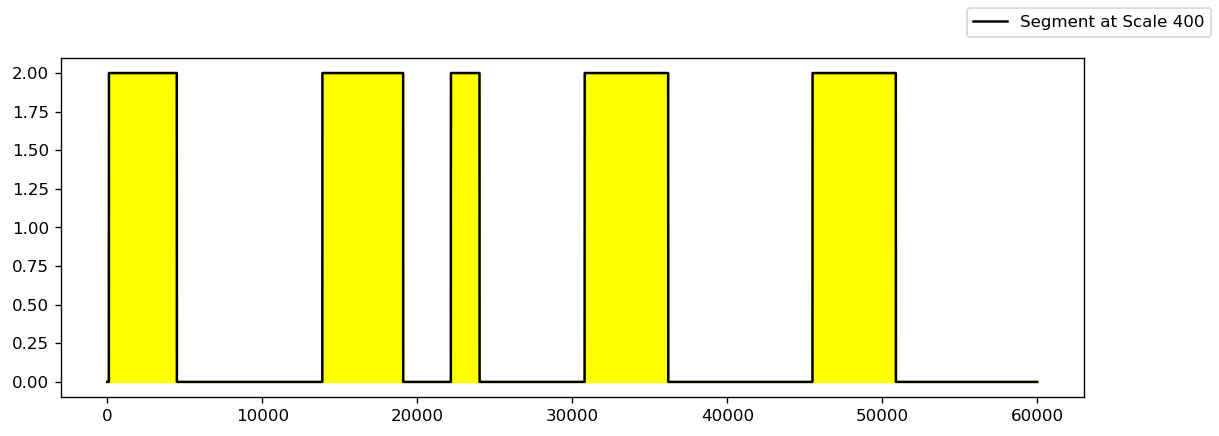

In [43]:
for j in range(np.shape(AllFingers)[0]):
    if j % 3 ==0:
            fig=plt.figure(figsize=(PlotWidthIn,PlotHeightIn),dpi=PlotDPI)
            y = SegmentMove(AllFingers[j][400,:],750)
            plt.plot(y, label = 'Segment at Scale 400')
            #plt.plot(AllFingers[j][200,:], label = 'Scale 200')
            plt.fill_between(np.linspace(0,np.size(y),np.size(y)), y, color='yellow')
            fig.legend()
            title = 'FP Scale 400 Seg fill ' + str(MetaData[j,0]) + '  ' + str(MetaData[j,1]) 
            plt.title(title)
            plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "")+FFormat)
            plt.close(fig)
        

In [ ]:
#for i in range figures = Parallel(n_jobs=num_cores)(delayed(PlotColorScales)(FP) for FP in plots)

Filters = [[np.asarray(DataOnlyMatrix[int(Bestmove)]).flatten(),'No Filter'],
           [np.asarray(Averages[int(Bestmove)]).flatten(), 'Rolling Average'],
           [np.asarray(waveFiltered[int(Bestmove)]).flatten(), 'Low Pass Filter'],
           [np.asarray(waveKalmaned[int(Bestmove)]).flatten(), 'Kalman filter']]
spacer = 15

Compare = Parallel(n_jobs=num_cores)(delayed(getThumbprint)([signal[0], 'dmey']) for signal in Filters)

plots=[]
i=0
for finger in Compare:
    if finger != 'fail':
        plots.append([finger, Filters[i][1]])
    else:
        print('fail',i)
    i+=1

figures = Parallel(n_jobs=num_cores)(delayed(PlotFingerPrint)(FP) for FP in plots)

for i in range(3):
    fig=plt.figure(figsize=(PlotWidthIn,PlotHeightIn),dpi=PlotDPI)
    plt.plot(Filters[0][0])
    plt.plot(Filters[i][0])
    title = 'Raw Data vs ' + Filters[i][1]
    plt.title(title)
    plt.savefig(location+title.replace(" ", "").replace(":", "").replace(",", "")+FFormat)
    plt.close(fig)